<a href="https://colab.research.google.com/github/yiyichanmyae/nlp/blob/master/SentenceBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 32.7 MB/s 
     |████████████████████████████████| 895 kB 39.6 MB/s 
     |████████████████████████████████| 596 kB 57.9 MB/s 
     |████████████████████████████████| 59 kB 6.6 MB/s 
     |████████████████████████████████| 3.3 MB 54.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## load the sentence-bert model from the HuggingFace model hub

In [5]:
!pip install torch

In [7]:
from transformers import AutoTokenizer, AutoModel
from torch.nn import functional as F

In [8]:
tokenizer = AutoTokenizer.from_pretrained('deepset/sentence_bert')
model = AutoModel.from_pretrained('deepset/sentence_bert')

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at deepset/sentence_bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
sentence = 'Who were you voting for in 2020?'
labels = ['business', 'art & culture', 'politics', 'entertainment']

## run inputs through model and mean-pool over the sequence dimension to get sequence-level representations

In [15]:
inputs = tokenizer.batch_encode_plus([sentence] + labels,
                                     return_tensors='pt',
                                     pad_to_max_length=True)
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
output = model(input_ids, attention_mask=attention_mask)[0]
sentence_rep = output[:1].mean(dim=1)
label_reps = output[1:].mean(dim=1)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [16]:
similarities = F.cosine_similarity(sentence_rep, label_reps)
closest = similarities.argsort(descending=True)
for ind in closest:
    print(f'label: {labels[ind]} \t similarity: {similarities[ind]}')

label: politics 	 similarity: 0.21518723666667938
label: entertainment 	 similarity: 0.02712976187467575
label: business 	 similarity: 0.021397119387984276
label: art & culture 	 similarity: -0.011321485973894596


 Note: This code snippet uses deepset/sentence_bert which is the smallest version of the S-BERT model. Our experiments use larger models which are currently available only in the sentence-transformers GitHub repo, which we hope to make available in the Hugging Face model hub soon.


One problem with this method is that Sentence-BERT is designed to learn effective sentence-level, not single- or multi-word representations like our class names. It is therefore reasonable to suppose that our label embeddings may not be as semantically salient as popular word-level embedding methods (i.e. word2vec). This is seen in the t-SNE visualization below where the data seems to cluster together by class (color) reasonably well, but the labels are poorly aligned. If we were to use word vectors as our label representations, however, we would need annotated data to learn an alignment between the S-BERT sequence representations and the word2vec label representations.



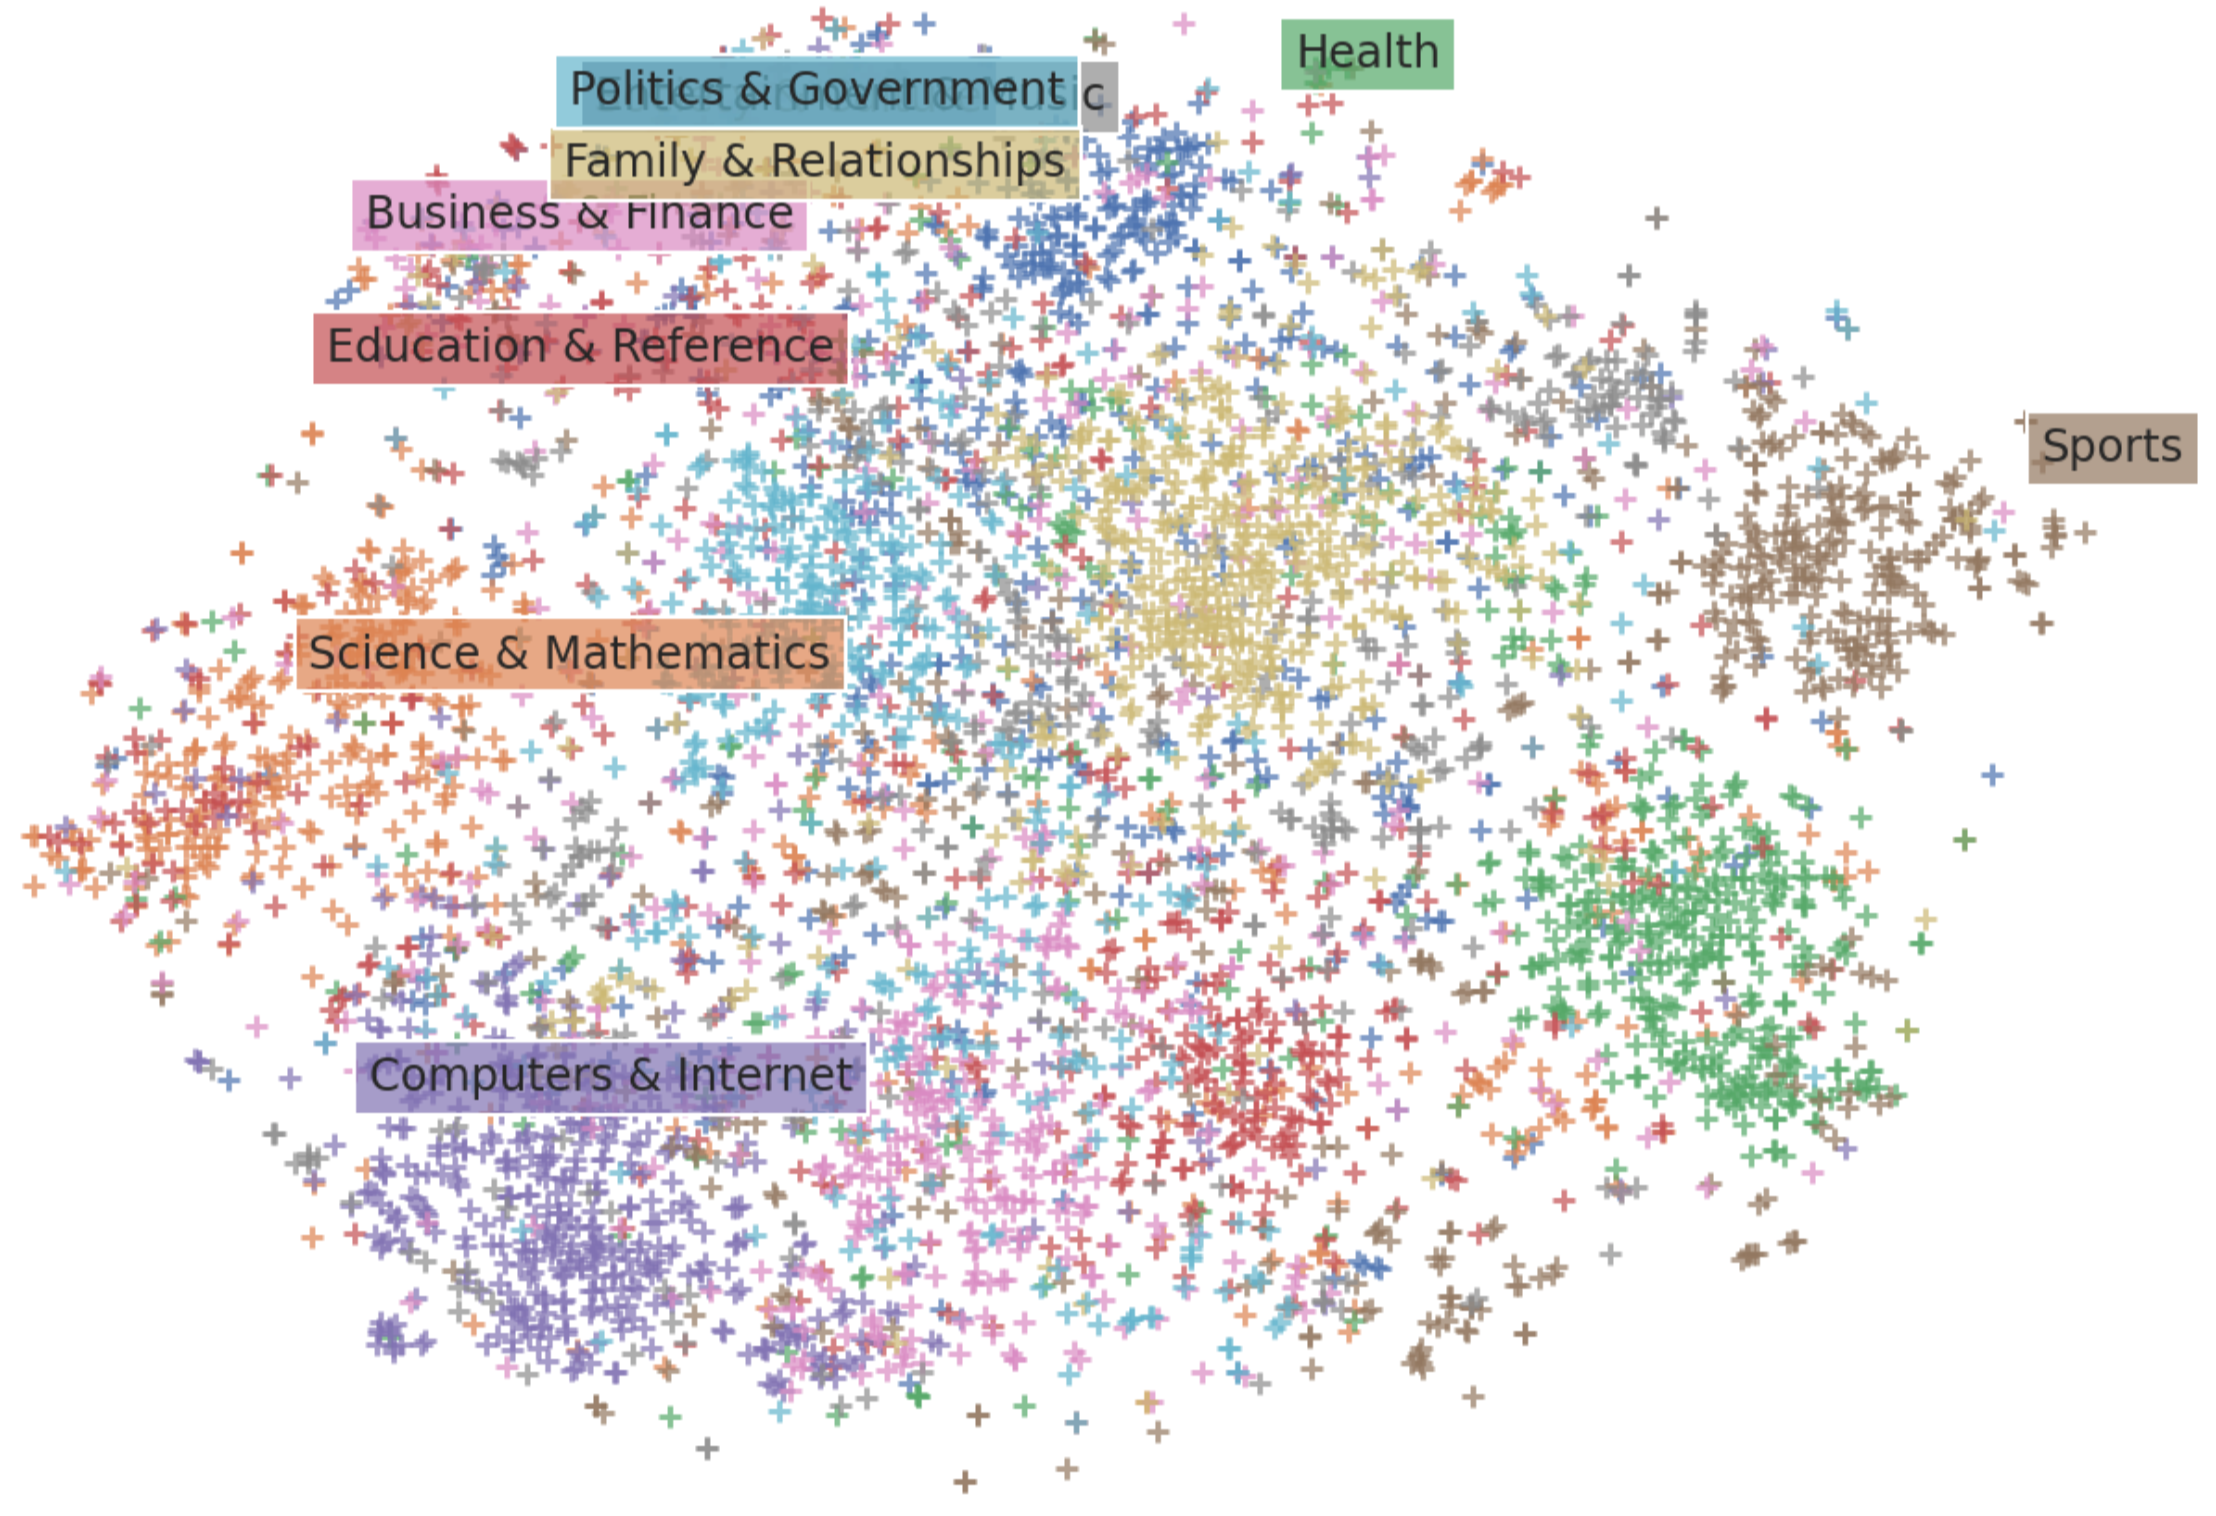

t-SNE visualization of Yahoo Answers S-BERT embeddings. Plotted points correpond to data and text boxes to corresponding labels. While some labels like 'Computers & Internet' do appear near their corresponding data clusteres in latent space, most are poorly aligned.



In some of our own internal experiments, we addressed this issue with the following procedure:

Take the top 
K
K most frequent words 
V
V in the vocabulary of a word2vec model
Obtain embeddings for each word using word2vec, 
Φ
word
(
V
)
Φ 
word
​
 (V)
Obtain embeddings for each word using S-BERT, 
Φ
sent
(
V
)
Φ 
sent
​
 (V)
Learn a least-squares linear projection matrix 
Z
Z with L2 regularization from 
Φ
sent
(
V
)
Φ 
sent
​
 (V) to 
Φ
word
(
V
)
Φ 
word
​
 (V)
Since we have only learned this projection for embeddings of single words, we cannot expect it to learn an effective mapping between S-BERT sequence representations and labels embedded with word2vec. Instead, we use 
Z
Z in our classification only as an additional transformation to S-BERT embeddings for both sequences and labels:

ˆ
c
=
arg
max
c
∈
C
 
cos
(
Φ
sent
(
x
)
Z
,
Φ
sent
(
c
)
Z
)
c
^
 =arg 
c∈C
max
​
 cos(Φ 
sent
​
 (x)Z,Φ 
sent
​
 (c)Z)
This procedure can be thought of as a kind of dimensionality reduction. As seen in the t-SNE visual below, this projection makes the label embeddings much better aligned with their corresponding data clusters while maintining the superior performance of S-BERT compared to pooled word vectors. Importantly, this procedure does not require any additional data beyond a word2vec dictionary sorted by word frequency.

On the Yahoo Answers topic classification task, we find an F1 of 
46.9
46.9 and 
31.2
31.2 with and without this projection step, respectively. For context, Yahoo Answers has 10 classes and supervised models get an accuracy in the mid 70s.

